# Problem Setting: Representation Learning.

This notebook demonstrates that the Convolutional Auto-Encoder can learn images and reconstruct its. Image dataset for this demo is the MNIST. The code of this notebook is written on the premise that the MNIST images are divided and arranged in directories for each label beforehand.

## Problem Solution:  Convolutional Auto-Encoder.

A stack of Convolutional Auto-Encoder (Masci, J., et al., 2011) forms a convolutional neural network(CNN), which are among the most successful models for supervised image classification.  Each Convolutional Auto-Encoder is trained using conventional on-line gradient descent without additional regularization terms.

In this library, Convolutional Auto-Encoder is also based on Encoder/Decoder scheme. The encoder is to the decoder what the Convolution is to the Deconvolution. The Deconvolution also called transposed convolutions "work by swapping the forward and backward passes of a convolution." (Dumoulin, V., & Visin, F. 2016, p20.)

### Modeling and Implementation.

Firstly, import Python modules for building Convolutional Auto-Encoder.

In [1]:
from accelbrainbase.computableloss._mxnet.l2_norm_loss import L2NormLoss
from accelbrainbase.extractabledata._mxnet.image_extractor import ImageExtractor
from accelbrainbase.iteratabledata._mxnet.unlabeled_image_iterator import UnlabeledImageIterator
from accelbrainbase.noiseabledata._mxnet.gauss_noise import GaussNoise
from accelbrainbase.observabledata._mxnet.convolutional_neural_networks import ConvolutionalNeuralNetworks
from accelbrainbase.observabledata._mxnet.convolutionalneuralnetworks.convolutional_auto_encoder import ConvolutionalAutoEncoder

In [3]:
import mxnet as mx
import mxnet.ndarray as nd
import numpy as np
import pandas as pd
from mxnet.gluon.nn import Conv2D
from mxnet.gluon.nn import Conv2DTranspose

If you want to observe the learning log, set `getLogger`.

In [2]:
from logging import getLogger, StreamHandler, NullHandler, DEBUG, ERROR

logger = getLogger("accelbrainbase")
handler = StreamHandler()
handler.setLevel(DEBUG)
logger.setLevel(DEBUG)
logger.addHandler(handler)

Build and initialize `ImageExtractor`, specifying parameters such as image size.

In [4]:
image_extractor = ImageExtractor(
    # `int` of image width.
    width=28,
    # `int` of image height.
    height=28,
    # `int` of image channel.
    channel=1,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu()
)

Build and initialize `UnlabeledImageIterator`, delegating `image_extractor` and specifying parameters such as file path to image files.

In [5]:
unlabeled_image_iterator = UnlabeledImageIterator(
    # is-a `ImageExtractor`.
    image_extractor=image_extractor,
    # `list` of paths to image files in learning.
    dir_list=[
        "../../../../Downloads/digit-recognizer/train/0/", 
        "../../../../Downloads/digit-recognizer/train/1/", 
        "../../../../Downloads/digit-recognizer/train/2/", 
        "../../../../Downloads/digit-recognizer/train/3/", 
        "../../../../Downloads/digit-recognizer/train/4/", 
        "../../../../Downloads/digit-recognizer/train/5/", 
        "../../../../Downloads/digit-recognizer/train/6/", 
        "../../../../Downloads/digit-recognizer/train/7/", 
        "../../../../Downloads/digit-recognizer/train/8/", 
        "../../../../Downloads/digit-recognizer/train/9/", 
    ],
    # `list` of paths to image files in test.
    test_dir_list=[
        "../../../../Downloads/digit-recognizer/test/0/", 
        "../../../../Downloads/digit-recognizer/test/1/", 
        "../../../../Downloads/digit-recognizer/test/2/", 
        "../../../../Downloads/digit-recognizer/test/3/", 
        "../../../../Downloads/digit-recognizer/test/4/", 
        "../../../../Downloads/digit-recognizer/test/5/", 
        "../../../../Downloads/digit-recognizer/test/6/", 
        "../../../../Downloads/digit-recognizer/test/7/", 
        "../../../../Downloads/digit-recognizer/test/8/", 
        "../../../../Downloads/digit-recognizer/test/9/", 
    ],
    # `int` of epochs.
    epochs=1000,
    # `int` of batch size.
    batch_size=40,
    # How to normalize pixel values of images.
    # - `z_score`: Z-Score normalization.
    # - `min_max`: Min-max normalization.
    # - others : This class will not normalize the data.
    norm_mode="z_score",
    # `float` of scaling factor for data.
    scale=1.0,
    # is-a `NoiseableData`.
    noiseable_data=GaussNoise(sigma=1e-03, mu=0.0),
)

Build and initialize loss function.

In [6]:
computable_loss = L2NormLoss()

Build and initialize `ConvolutionalNeuralNetworks` as an encoder.

In [7]:
encoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2D`.
        Conv2D(
            channels=16,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ), 
        Conv2D(
            channels=32,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "relu"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), BatchNorm()],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalNeuralNetworks` as a decoder.

In [9]:
decoder = ConvolutionalNeuralNetworks(
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # `list` of int` of the number of units in hidden layers.
    hidden_units_list=[
        # `mxnet.gluon.nn.Conv2DTranspose`.
        Conv2DTranspose(
            channels=16,
            kernel_size=3,
            strides=(1, 1),
            padding=(1, 1),
        ), 
        Conv2DTranspose(
            channels=1,
            kernel_size=6,
            strides=(2, 2),
            padding=(1, 1),
        ),
    ],
    # `list` of act_type` in `mxnet.ndarray.Activation` or `mxnet.symbol.Activation` in input gate.
    hidden_activation_list=["relu", "identity"],
    # `list` of `float` of dropout rate.
    hidden_dropout_rate_list=[0.0, 0.0],
    # `list` of `mxnet.gluon.nn.BatchNorm`.
    hidden_batch_norm_list=[BatchNorm(), None],
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Build and initialize `ConvolutionalAutoEncoder`, delegating `encoder` and `decoder`.

In [10]:
CAE = ConvolutionalAutoEncoder(
    # is-a `ConvolutionalNeuralNetworks`.
    encoder=encoder,
    # is-a `ConvolutionalNeuralNetworks`.
    decoder=decoder,
    # is-a `ComputableLoss` or `mxnet.gluon.loss`.
    computable_loss=computable_loss,
    # is-a `mxnet.initializer` for parameters of model. If `None`, it is drawing from the Xavier distribution.
    initializer=None,
    # `float` of learning rate.
    learning_rate=1e-03,
    # `float` of attenuate the `learning_rate` by a factor of this value every `attenuate_epoch`.
    learning_attenuate_rate=1.0,
    # `int` of attenuate the `learning_rate` by a factor of `learning_attenuate_rate` every `attenuate_epoch`.
    attenuate_epoch=50,
    # `bool` of flag to tied weights or not.
    tied_weights_flag=True,
    # `str` of name of optimizer.
    optimizer_name="SGD",
    # Call `mxnet.gluon.HybridBlock.hybridize()` or not.
    hybridize_flag=True,
    # `mx.gpu()` or `mx.cpu()`.
    ctx=mx.gpu(),
)

Start learning.

In [11]:
CAE.learn(unlabeled_image_iterator)

Epochs: 100 Train loss: 2.0903406 Test loss: 2.2757978
Epochs: 200 Train loss: 2.1267376 Test loss: 2.124045
Epochs: 300 Train loss: 1.4967544 Test loss: 1.6124287
Epochs: 400 Train loss: 0.5461731 Test loss: 0.5038663
Epochs: 500 Train loss: 0.40999413 Test loss: 0.39185923
Epochs: 600 Train loss: 0.37776417 Test loss: 0.42110586
Epochs: 700 Train loss: 0.4141701 Test loss: 0.35787326
Epochs: 800 Train loss: 0.31206304 Test loss: 0.38024205
Epochs: 900 Train loss: 0.31439528 Test loss: 0.36593825
Epochs: 1000 Train loss: 0.33468017 Test loss: 0.3181389
end. 


Visualize reconstruction losses.

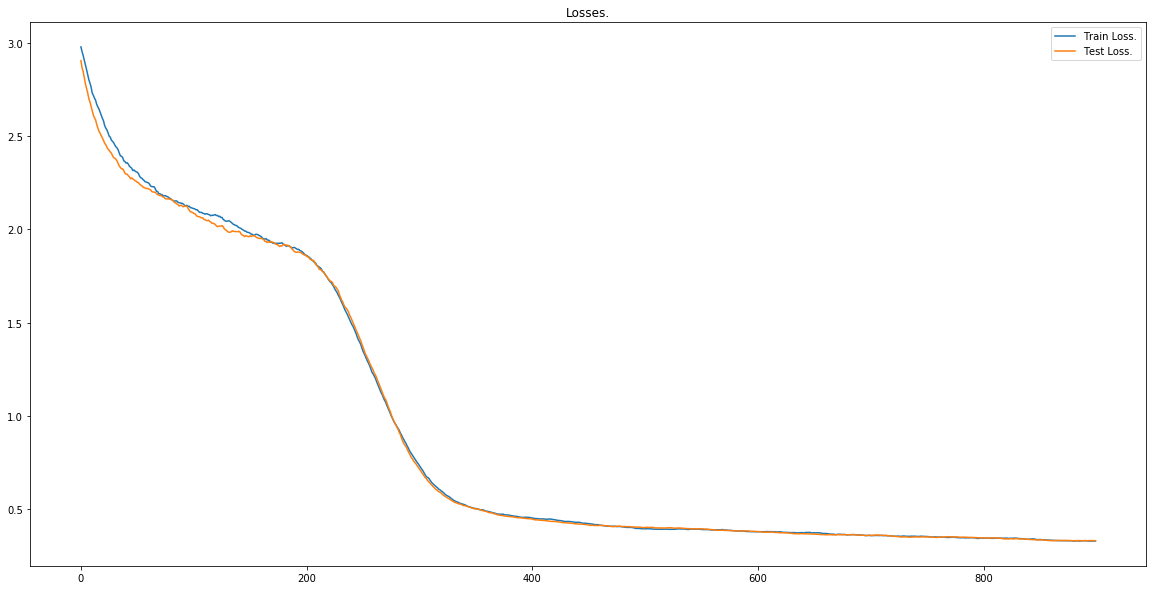

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

def moving_avg(arr, window=50):
    return np.convolve(arr, np.ones(window) / window, mode='same')[window:-window]

plt.figure(figsize=(20, 10))
plt.plot(moving_avg(CAE.loss_arr[:, 0]), label="Train Loss.")
plt.plot(moving_avg(CAE.loss_arr[:, 1]), label="Test Loss.")
plt.legend()
plt.title("Losses.")
plt.show()

You can observe reconstructed images as follows.

In [14]:
test_arr = None
for _, _, _test_arr, _ in unlabeled_image_iterator.generate_learned_samples():
    test_arr = _test_arr
    break

In [15]:
inferenced_arr = CAE.inference(test_arr)

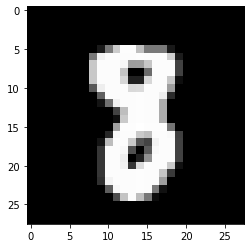

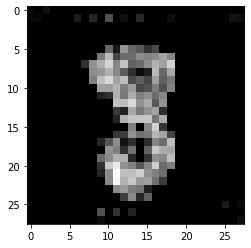

In [24]:
plt.imshow(test_arr[0].asnumpy().reshape(28, 28), cmap="gray")
plt.show()

plt.imshow(inferenced_arr[0].asnumpy().reshape(28, 28), cmap="gray")
plt.show()

**Note** that it is more important not to confirm the reconstructed image, but to confirm that the feature points obtained by representation learning are not excessive information loss, information overload, or noisy state.

You can also check the feature points as follows.

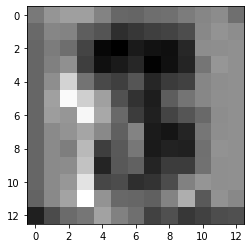

In [26]:
plt.imshow(CAE.feature_points_arr[0].asnumpy().mean(axis=0), cmap="gray")
plt.show()

## For ML Ops.

This model inherits [HybridBlock](https://gluon.mxnet.io/chapter07_distributed-learning/hybridize.html) from [mxnet.gluon](https://mxnet.incubator.apache.org/api/python/docs/api/gluon/index.html). Functions for common ML Ops such as saving and loading parameters are provided by [HybridBlock](https://mxnet.apache.org/api/python/docs/api/gluon/hybrid_block.html).

# References

- Dumoulin, V., & V,kisin, F. (2016). A guide to convolution arithmetic for deep learning. arXiv preprint arXiv:1603.07285.
- Masci, J., Meier, U., Cireşan, D., & Schmidhuber, J. (2011, June). Stacked convolutional auto-encoders for hierarchical feature extraction. In International Conference on Artificial Neural Networks (pp. 52-59). Springer, Berlin, Heidelberg.